In [2]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from IPython.display import Latex

<h1> Data

In [3]:
def func(x,a,b):
    return a*x**2+b*x

In [4]:
def genData(xMin,xMax,theta,sigma,N):

    x = np.linspace(xMin,xMax,N)
    y = np.empty(N)

    for i in range(N):
        
        y[i] = func(x[i],theta[0],theta[1]) + np.random.normal(0,sigma)

    return x,y

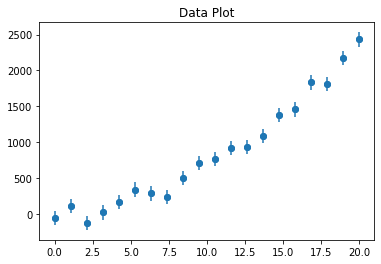

In [5]:
xmin,xmax = 0 , 20
N = 20
sigma = 100

a,b = 6,2

data = genData(xmin,xmax,(a,b),sigma,N)

sigmay = np.array([sigma for i in range(N)])

plt.scatter(data[0],data[1])
plt.title("Data Plot")
plt.errorbar(data[0],data[1], xerr=0,yerr=sigmay, linestyle = 'None', marker='o')
plt.show()

<h4>Fitting the data

In [6]:
dataFit = LeastSquares(data[0],data[1],sigmay,func)

my_minuit = Minuit(dataFit,a=0,b=0)
my_minuit.migrad()
my_minuit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.04 (χ²/ndof = 0.8)      │              Nfcn = 41               │
│ EDM = 1.29e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    5.4    │    0.5    │            │            │         │         │       │
│ 1 │ b    │    11     │     8     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────┐
│   │     a     b │
├───┼─────────────┤
│ a │ 0.232 -3.58 │
│ b │ -3.58  58.7 │
└───┴─────────────┘

In [7]:
# for par, val, err in zip (my_minuit.parameters, my_minuit.values, my_minuit.errors) :
#     print(f'{par} = {val:.3f} +/- {err:.3f}')

Latex(f"$$a = {a} \\newline b = {b} \\newline a = {my_minuit.values[0]} \pm {my_minuit.errors[0]} \\newline b = {my_minuit.values[1]} \pm {my_minuit.errors[1]}$$")

<IPython.core.display.Latex object>